# Demo: Calibration Directly using Simulator (no emulator in MCMC)

- Author: Arthur Lui
- Email: alui@lanl.gov
- Date: 18 Feb, 2022

WIP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sepia
from sepia import SepiaData, SepiaModel
from sepia.contrib.emufree_calib_model import create_D_basis, gaussian_kernel_basis
from sepia.contrib.emufree_calib_model import sqexpkernel
from scipy.linalg import block_diag
from sepia.contrib.ppl import distributions as dist
from sepia.contrib.ppl.distributions import GP
import numpy as np
from tqdm import trange, tqdm
from scipy.spatial import distance

import matplotlib.pyplot as plt
from matplotlib import animation
plt.rcParams["animation.html"] = "html5"  # or jshtml, which results in larger but more interactive graphs.
orig_dpi = 72  # original dpi.

In [3]:
# Simulator gridsize.
sim_gridsize = 60

# Simulator grid.
sim_grid = np.linspace(0, 1, sim_gridsize)

# Simulator.
def eta(x, t):
    return t[0] + 0.25 * np.sin(sim_grid * 4 * np.pi) * x[0]
# Discrepancy.
def delta(x, a=3):
    return np.clip(sim_grid - np.power(x[0], 0.2), 0, np.inf) * np.sqrt(x[0] * a)

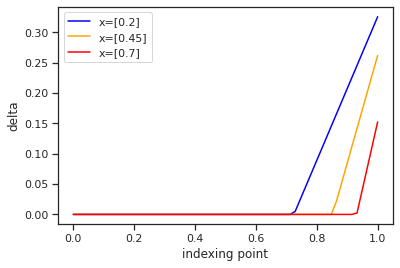

In [4]:
# Generate data.
np.random.seed(0)

num_obs = 3
xs = np.linspace(.2, .7, num_obs)[:, None]
theta = np.array([.7])
lam_true = 0.01
a = 7

colors = ["blue", "orange", "red"]
true_discrepancy = [delta(x, a=a) for x in xs]
ys = [np.random.normal(eta(x, theta) + delta(x, a=a), lam_true) for x in xs]  # TODO: wrong?
y = np.concatenate(ys)

for i, x in enumerate(xs):
    plt.plot(sim_grid, true_discrepancy[i], label=f"x={x}", color=colors[i])
plt.legend()
plt.xlabel("indexing point")
plt.ylabel("delta")
plt.show()

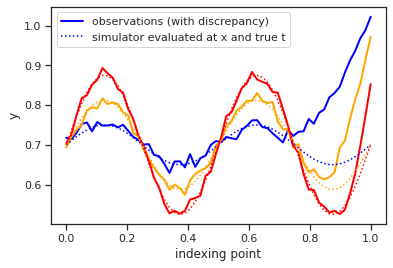

In [5]:
for i, x in enumerate(xs):
    # plt.plot(sim_grid, ys[i], lw=3)
    label = None if i > 0 else "observations (with discrepancy)"
    plt.plot(sim_grid, ys[i], label=label, lw=2, color=colors[i])
for i, x in enumerate(xs):
    label = None if i > 0 else "simulator evaluated at x and true t"
    plt.plot(sim_grid, eta(x, theta), label=label, ls=":", color=colors[i])
plt.xlabel("indexing point")
plt.ylabel("y")
plt.legend()
plt.show()

In [6]:
# Base sepia data.
# TODO: sim_grid should be in SepiaData, I think y_obs_ind?
sepia_data = SepiaData(x_obs=xs, y_obs=ys, theta_dim=1, eta=eta, Sigy=np.eye(y.shape[0]))

def hinge(x, c):
    return np.maximum(x - c.T, 0)

# Create D basis.
# TODO: Allow user to specify some basic bases (e.g. Gaussian kernels, linear, constant, hinge).
num_basis = 21
knots = np.linspace(0, 1, num_basis)[:, None]

# Gaussian kernel basis.
D = create_D_basis([sim_grid[:, None] for _ in xs], knots, sd=1/(num_basis-1))

# Hinge basis.
# D = create_D_basis([sim_grid[:, None] for _ in xs], knots, basis=hinge)

sepia_data.create_D_basis(D_obs=D, num_basis=num_basis)

In [7]:
sepia_model = SepiaModel(sepia_data)

In [8]:
result = sepia_model.do_mcmc(1000, burn=3000, thinning=3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:16<00:00, 373.54it/s]


In [9]:
print("result.keys(): ", result.keys())
samples = result['samples']

print("samples.keys(): ", samples.keys())

result.keys():  dict_keys(['mcmc', 'samples', 'init_state', 'kernel', 'window', 'burn', 'num_samples', 'thinning'])
samples.keys():  dict_keys(['length_scale', 'process_sd', 't', 'lam'])


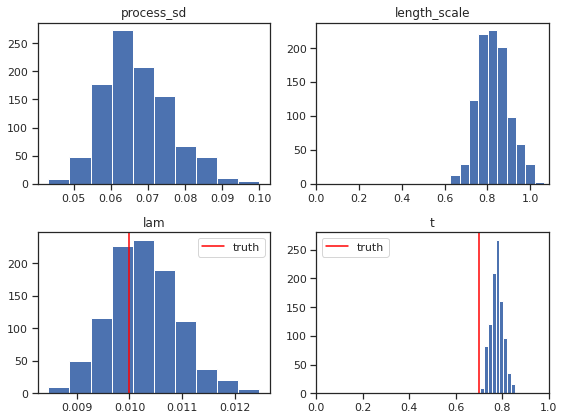

In [10]:
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.hist(samples["process_sd"])
plt.title("process_sd")

plt.subplot(2, 2, 2)
plt.hist(samples['length_scale'])
plt.title("length_scale")
plt.xlim(0)

plt.subplot(2, 2, 3)
plt.hist(samples['lam'])
plt.title("lam")
plt.axvline(lam_true, color="red", label="truth")
plt.legend()

plt.subplot(2, 2, 4)
plt.hist(samples["t"].flatten())
plt.title("t")
plt.xlim(0, 1)
plt.axvline(theta, color="red", label="truth")
plt.legend()

plt.tight_layout()
plt.show()

***

## TODO

18 Feb, 2022.
- [ ] Allow user to specify `sim_grid` in `SepiaData`
- [ ] Allow user to specify a bases form for `D` (e.g. hinges, constant, linear, Gaussian kernel)
- [X] posterior predictive method, optionally at new locations (`xs`).
- [X] posterior distribution of discrepancy (`delta`), optionally at new locations (`xs`).

In [11]:
# TODO: Move into src.

def make_cov(X, length_scale, process_sd):
    Sigma = np.kron(
        sqexpkernel(
            X,
            length_scale=length_scale,
            process_sd=process_sd
        ),
        np.eye(num_basis)
    )
    
    # Gaussian kernel basis.
    D = create_D_basis([sim_grid[:, None] for _ in X], knots=knots, sd=1 / (num_basis-1))
    
    # Hinge basis.
    # D = create_D_basis([sim_grid[:, None] for _ in X], knots=knots, basis=hinge)
    
    marg_cov = D @ Sigma @ D.T # + lam ** 2 * np.eye(D.shape[0])
    
    return marg_cov

def make_mean(X, t):
    return np.concatenate([
        eta(x, t)
        for x in X
    ])

In [12]:
# TODO: Move into src.

def get_post(xnew, samples, i):
    def mean_fn(X):
        return make_mean(X, t=samples["t"][i])

    def cov_fn(X):
        return make_cov(
            X,
            length_scale=samples["length_scale"][i],
            process_sd=samples['process_sd'][i],
        )

    gp = GP(cov_fn=cov_fn, mean_fn=mean_fn)
    cov_obs = samples["lam"][i] ** 2 * np.eye(y.shape[0])
    post = gp.posterior(X=xs, y=y, Xnew=xnew, cov_obs=cov_obs)
    return np.random.normal(post.mean, np.sqrt(np.diag(post.cov)))

num_mcmc_samples = len(samples[list(samples.keys())[0]])
xnew = np.sort(np.concatenate([xs.flatten(), np.linspace(0, 1, 30)]))[:, None]
post = np.stack([get_post(xnew, samples, i) for i in trange(num_mcmc_samples)])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:20<00:00, 12.43it/s]


In [13]:
# TODO: Move into src.
post_delta = np.stack([post[i] - make_mean(xnew, t) for i, t in enumerate(samples['t'])])

In [14]:
# TODO: Move into src.
post_y = np.stack([np.random.normal(p, samples['lam'][i]) for i, p in enumerate(post)])

In [15]:
post.shape

(1000, 1980)

In [16]:
class Subset:
    def __init__(self, size):
        self.size = size
    def get(self, y, i):
        start = self.size * i
        end = start + self.size
        return y[start:end]

In [17]:
# Posterior Predictive Mean Function at (old and) new locations.

def make_plotter(fig):
    subset = Subset(sim_gridsize)

    def plotter(i, x):
        p = subset.get
        mean = subset.get(post_y.mean(0), i)
        
        if x in xs.tolist():
            j = np.argwhere(xs == x).flatten()[0]
            plt.scatter(sim_grid, subset.get(y, j), s=10, color="orange", label="data")
            
        plt.plot(sim_grid, mean, lw=3, label="prediction")
        plt.plot(sim_grid, eta(x, theta) + delta(x, a=a), label="truth")

        lower = subset.get(np.quantile(post_y, 0.025, 0), i)
        upper = subset.get(np.quantile(post_y, 0.975, 0), i)
        plt.fill_between(sim_grid, lower, upper, alpha=0.1, color="blue")
        plt.ylim(0.3, 1.1)
        plt.title(f"xobs: {x[0]:.3f}")
        plt.legend(loc="lower left")
        
    return plotter

def make_delta_plotter(fig):
    subset = Subset(sim_gridsize)

    def plotter(i, x):
        mean = subset.get(post_delta.mean(0), i)
        
        plt.plot(sim_grid, mean, lw=3, label="prediction")
        plt.plot(sim_grid, delta(x, a=a), label="truth")

        lower = subset.get(np.quantile(post_delta, 0.025, 0), i)
        upper = subset.get(np.quantile(post_delta, 0.975, 0), i)
        plt.fill_between(sim_grid, lower, upper, alpha=0.1, color="blue")
        plt.ylim(-0.3, 0.3)
        plt.title(f"xobs: {x[0]:.3f}")
        plt.ylabel("discrepancy")
        plt.legend(loc="lower left")
        
    return plotter

# Posterior predictive distribution (y at new locations)

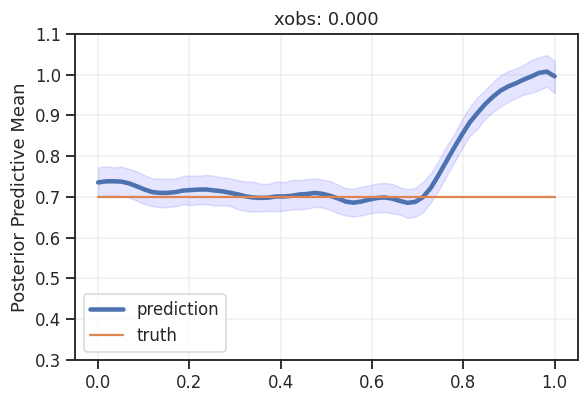

In [18]:
# Increase resolution.
plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots();
plotter = make_plotter(fig)

def animate(t):
    plt.cla();
    plotter(t, xnew[t]);
    plt.grid(lw=0.3);
    plt.ylabel("Posterior Predictive Mean")
    
def make_reversing_frames(n):
    frames = np.arange(n)
    return np.concatenate([frames, frames[::-1]])

frames = make_reversing_frames(len(xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim

# Posterior predictive distribution of the discrepancy (at new locations)

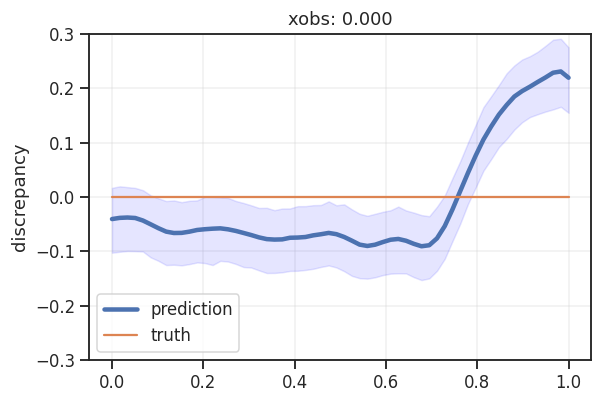

In [19]:
plt.rcParams['figure.dpi'] = orig_dpi * 1.5

fig, ax = plt.subplots();
plotter = make_delta_plotter(fig)

def animate(t):
    plt.cla();
    plotter(t, xnew[t]);
    plt.grid(lw=0.3);
    
frames = make_reversing_frames(len(xnew))
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=120)
plt.rcParams['figure.dpi'] = orig_dpi

# NOTE: This video cannot be viewed on GitHub, but you can view it on nbviewer.
anim

# NOTE
- scaling of D
    - the ratio between the columns needs to be preserved (think about the gaussian kernel basis)
    - the ratio between the rows also needs some preservation (otherwise the covariates are all the same) 
    - consider `D = D / np.abs(D).max()`

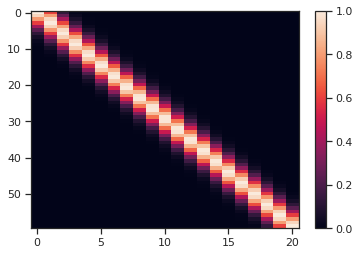

In [20]:
plt.imshow(D[:sim_gridsize, :num_basis], aspect="auto")
plt.colorbar()

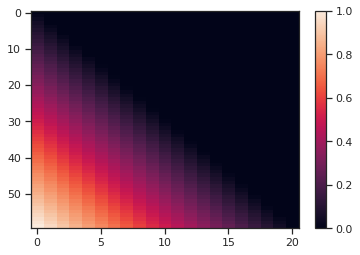

In [21]:
plt.imshow(create_D_basis([sim_grid[:, None] for _ in xs], knots, basis=hinge)[:sim_gridsize, :num_basis], aspect="auto")
plt.colorbar()